In [1]:
import os
import io
import datetime
from typing import Optional, Tuple
from functools import partial

import gym
import numpy as np
import torch
from tianshou.data import Collector, VectorReplayBuffer, PrioritizedVectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.env.pettingzoo_env import PettingZooEnv
from tianshou.policy import BasePolicy, DQNPolicy, MultiAgentPolicyManager, RandomPolicy
from tianshou.trainer import offpolicy_trainer
from torch.utils.tensorboard import SummaryWriter
from tianshou.utils import TensorboardLogger

#from torchviz import make_dot

from TaskAllocation.RL_Policies.Custom_Classes import CustomNet
from TaskAllocation.RL_Policies.Custom_Classes import CustomCollector
from TaskAllocation.RL_Policies.Custom_Classes import CustomParallelToAECWrapper

#from CustomClass_multi_head import CustomNet
from TaskAllocation.RL_Policies.Custom_Classes_simplified import CustomNetSimple
#from Custom_Classes_simplified import CustomCollectorSimple
#from Custom_Classes_simplified import CustomParallelToAECWrapperSimple

from TaskAllocation.RL_Policies.CustomClasses_Transformer_Reduced import CustomNetReduced
from TaskAllocation.RL_Policies.CustomClass_MultiHead_Transformer import CustomNetMultiHead

from mUAV_TA.MultiDroneEnvUtils import agentEnvOptions

from mUAV_TA.DroneEnv import MultiUAVEnv
#from tianshou_DQN import train
model = "CustomNetMultiHead" # "CustomNet" or "CustomNetSimple" or "CustomNetReduced" or "CustomNetMultiHead"
test_num = "_Eval_TBTA_Relative_Representation_01"

train_env_num = 30
test_env_num = 1

name = model + test_num

load_policy_name = f'policy_CustomNetMultiHead_Eval_TBTA_02_simplified_UCF1_new_rew_updR.pth'
save_policy_name = f'policy_{name}.pth'
policy_path = "dqn_Custom"
load_model = False

# log
now = datetime.datetime.now().strftime("%y%m%d-%H%M%S")
log_name = name + str(now)

log_path = os.path.join('./', "Logs", "dqn", log_name)

dqn_params = {"discount_factor": 0.98, 
              "estimation_step": 100, 
              "target_update_freq": 900,
              "optminizer": "Adam",
              "lr": 5e-5  }

trainer_params = {"max_epoch": 200,
                  "step_per_epoch": 450 * train_env_num,
                  "step_per_collect": 300 * train_env_num,
                  "episode_per_test": 1,
                  "batch_size" : 600,
                  "update_per_step": 3 / (50 * train_env_num),
                  "tn_eps_max": 0.85,
                  "ts_eps_max": 0.0,
                  }

config_default = agentEnvOptions()
Run_Data = f'''{name}  
Loaded_Model: {load_policy_name if load_model else "no"}  
log_path: {log_path}  
train/test_env_num: {train_env_num} / {test_env_num}  
model: {model}  
dqn_params: {dqn_params}  
trainer_params: {trainer_params} 
 
--------- Env ------------  

Rewards Only Final Quality and Threats
random_init_pos      : {config_default.random_init_pos}
max_time_steps       : {config_default.max_time_steps}
simulation_frame_rate: {config_default.simulation_frame_rate}
Agents               : {config_default.agents}
tasks                : {config_default.tasks}
random_init_pos      : {config_default.random_init_pos} 
threats              : 4
'''


model_load_path = os.path.join(policy_path, load_policy_name)  
model_save_path = os.path.join(policy_path, save_policy_name)        
os.makedirs(os.path.join(policy_path), exist_ok=True)  
os.makedirs(os.path.join(log_path), exist_ok=True)

def generate_dummy_observation(batch_size=1, sequence_length=31, feature_dim=12):
    # Generate a random tensor with the given shape
    dummy_obs = torch.randn(batch_size, sequence_length, feature_dim)

    return dummy_obs

def _get_agents(
    agent_learn: Optional[BasePolicy] = None,
    agent_opponent: Optional[BasePolicy] = None,
    optim: Optional[torch.optim.Optimizer] = None,
    policy_load_path = None,
) -> Tuple[BasePolicy, torch.optim.Optimizer, list]:
    
    env = _get_env()
    agent_name = env.agents[0]  # Get the name of the first agent

    #print(env.observation_space )
    agent_observation_space = env.observation_space # assuming 'agent0' is a valid agent name
    state_shape_agent_position = agent_observation_space["agent_position"].shape[0]
    state_shape_agent_state = agent_observation_space["agent_state"].shape[0]
    state_shape_agent_type = agent_observation_space["agent_type"].shape[0]
    state_shape_next_free_time = agent_observation_space["next_free_time"].shape[0]
    state_shape_position_after_last_task = agent_observation_space["position_after_last_task"].shape[0]       
    #state_shape_agent_relay_area = agent_observation_space["agent_relay_area"].shape[0]
        
    state_shape_agent = (state_shape_agent_position + state_shape_agent_state +
                     state_shape_agent_type+ state_shape_next_free_time + state_shape_position_after_last_task #+                     
                     #state_shape_agent_relay_area
                     )                 
    

    state_shape_task = 31 * 12 #env.observation_space["tasks_info"].shape[0]
                  
    action_shape = env.action_space[agent_name].shape[0]
    #action_shape = env.action_space[agent_name].n
               
    if agent_learn is None:
        # model
        if model == "CustomNet":        
            net = CustomNet(
                state_shape_agent=state_shape_agent,
                state_shape_task=state_shape_task,
                action_shape=action_shape,
                hidden_sizes=[128,128],
                device="cuda" if torch.cuda.is_available() else "cpu",
            ).to("cuda" if torch.cuda.is_available() else "cpu")
        
        if model == "CustomNetSimple":
            net = CustomNetSimple(            
                state_shape_agent=state_shape_agent,
                state_shape_task=state_shape_task,
                action_shape=action_shape,
                hidden_sizes=[128,128],
                device="cuda" if torch.cuda.is_available() else "cpu",
            ).to("cuda" if torch.cuda.is_available() else "cpu")
        
        if model == "CustomNetReduced":
            net = CustomNetReduced(            
                state_shape_agent=state_shape_agent,
                state_shape_task=state_shape_task,
                action_shape=action_shape,
                hidden_sizes=[128,128],
                device="cuda" if torch.cuda.is_available() else "cpu",
            ).to("cuda" if torch.cuda.is_available() else "cpu")
        
        if model == "CustomNetMultiHead":
            net = CustomNetMultiHead(
                state_shape_agent=state_shape_agent,
                state_shape_task=state_shape_task,
                action_shape=action_shape,
                hidden_sizes=[128,128],
                device="cuda" if torch.cuda.is_available() else "cpu",
            ).to("cuda" if torch.cuda.is_available() else "cpu")

    
        if optim is None:
            optim = torch.optim.Adam(net.parameters(), lr=dqn_params["lr"])
    
        agent_learn = DQNPolicy(
            model=net,
            optim=optim,
            discount_factor= dqn_params["discount_factor"],
            estimation_step=dqn_params["estimation_step"],
            target_update_freq=dqn_params["target_update_freq"],
        )  
        
        if load_model == True:
            # Load the saved checkpoint             
            agent_learn.load_state_dict(torch.load(model_load_path))
            print(f'Loaded-> {model_load_path}')
            
        
        agents = [agent_learn for _ in range(len(env.agents))]
        
    policy = MultiAgentPolicyManager(agents, env)  
        
    return policy, optim, env.agents


def _get_env():
    """This function is needed to provide callables for DummyVectorEnv."""   
    env_paralell = MultiUAVEnv()
    #env = parallel_to_aec_wrapper(env_paralell)    
    env = CustomParallelToAECWrapper(env_paralell)
    
    return PettingZooEnv(env)

print(Run_Data)


CustomNetMultiHead_Eval_TBTA_Relative_Representation_01  
Loaded_Model: no  
log_path: ./Logs\dqn\CustomNetMultiHead_Eval_TBTA_Relative_Representation_01231013-223240  
train/test_env_num: 30 / 1  
model: CustomNetMultiHead  
dqn_params: {'discount_factor': 0.98, 'estimation_step': 100, 'target_update_freq': 900, 'optminizer': 'Adam', 'lr': 5e-05}  
trainer_params: {'max_epoch': 200, 'step_per_epoch': 13500, 'step_per_collect': 9000, 'episode_per_test': 1, 'batch_size': 600, 'update_per_step': 0.002, 'tn_eps_max': 0.85, 'ts_eps_max': 0.0} 
 
--------- Env ------------  

Rewards Only Final Quality and Threats
random_init_pos      : False
max_time_steps       : 150
simulation_frame_rate: 0.01
Agents               : {'F1': 4, 'F2': 2, 'R1': 6}
tasks                : {'Att': 4, 'Rec': 16, 'Hold': 4}
random_init_pos      : False 
threats              : 4



In [2]:
if __name__ == "__main__":
                        
    torch.set_grad_enabled(True) 
    # ======== Step 1: Environment setup =========
    train_envs = DummyVectorEnv([_get_env for _ in range(train_env_num)])
    test_envs = DummyVectorEnv([_get_env for _ in range(test_env_num)]) 

    # seed
    seed = 0
    np.random.seed(seed)
    
    torch.manual_seed(seed)

    train_envs.seed(seed)
    test_envs.seed(seed)

    # ======== Step 2: Agent setup =========
    policy, optim, agents = _get_agents()    

    # ======== Step 3: Collector setup =========
    train_collector = CustomCollector(
        policy,
        train_envs,
        #VectorReplayBuffer(100_000, len(train_envs)),
        PrioritizedVectorReplayBuffer( 100_000, len(train_envs), alpha=0.6, beta=0.4) , 
        #ListReplayBuffer(100000)       
        exploration_noise=True             
    )
    test_collector = CustomCollector(policy, test_envs, exploration_noise=True)
     
    print("Buffer Warming Up ")
    
    for i in range(10):#int(trainer_params['batch_size'] / (300 * 10 ) )):
        
        train_collector.collect(n_episode=20)#,random=True) #trainer_params['batch_size'] * train_env_num))
        #train_collector.collect(n_step=300 * 10)
        print(".", end="") 
    
    print("\nBuffer Lenght: ", len(train_collector.buffer)/ 150 ) 
    #train_collector.collect(n_episode=trainer_params['batch_size'])
    #test_collector.collect(n_episode=2 )
    #test_collector.collect(n_step=trainer_params['batch size'] * train_env_num)
    
    # ======== tensorboard logging setup =========
    #         
    writer = SummaryWriter(log_path)
    writer.add_text("Config", str(Run_Data))
    writer.add_text("Model", str(policy.policies['agent0'].model).replace('\n', '  \n'))    
    
    logger = TensorboardLogger(writer)

    global_step_holder = [0]  
    # ======== Step 4: Callback functions setup =========
    def save_best_fn(policy):                
        print("Best Saved")
        torch.save(policy.policies[agents[0]].state_dict(), model_save_path)

    def stop_fn(mean_rewards):
        return mean_rewards >= 9939.0

    def train_fn(epoch, env_step):
        epsilon = trainer_params['tn_eps_max'] - (trainer_params['tn_eps_max'] - trainer_params['tn_eps_max']/100)*(epoch/trainer_params['max_epoch'])  
        policy.policies[agents[0]].set_eps(epsilon)

    def test_fn(epoch, env_step):
        epsilon = trainer_params['ts_eps_max']#0.01#max(0.001, 0.1 - epoch * 0.001)
        policy.policies[agents[0]].set_eps(epsilon)
        
    def reward_metric(rews):       
        #print(rews)  
        global_step_holder[0] += 1      
        return rews.mean()#[:,0]


    #Define the hook function
    def register_activation_hook(module, input, output, layer_name, writer, global_step_holder):
        #print(f"Hook executed for {layer_name} at step {global_step_holder[0]}")
        if isinstance(output, tuple):
            output = output[0]  # If the output is a tuple, use the first element
        writer.add_histogram(f"activations/{layer_name}", output, global_step_holder[0])

    #Register the hook
    #hook_function0 = partial(register_activation_hook, layer_name="task_embeddings", writer=writer, global_step_holder=global_step_holder)    
    #hook0 = policy.policies['agent0'].model.task_encoder.register_forward_hook(hook_function0)

    #Register the hook
    # hook_function1 = partial(register_activation_hook, layer_name="attention_output2", writer=writer, global_step_holder=global_step_holder)    
    # hook1 = policy.policies['agent0'].model.task_encoder.register_forward_hook(hook_function1)

    #Register the hook
    #hook_function2 = partial(register_activation_hook, layer_name="attention_output2", writer=writer, global_step_holder=global_step_holder)    
    #hook2 = policy.policies['agent0'].model.task_encoder.register_forward_hook(hook_function2)

    #Register the hook
    #hook_function3 = partial(register_activation_hook, layer_name="tasks_info", writer=writer, global_step_holder=global_step_holder)    
    #hook3 = policy.policies['agent0'].model.task_encoder.register_forward_hook(hook_function3)
        
    #Add Logger Details
    def log_gradients(policy, writer, global_step_holder, **kwargs):
        for name, param in policy.model.named_parameters():
            writer.add_histogram(f"{name}.grad", param.grad, global_step_holder[0])    

    #Modify the hook definition to pass the writer and global_step_holder
    # policy.policies['agent0'].post_optim_hook = partial(log_gradients, writer=writer, global_step_holder=global_step_holder)
        
   
    def condensed_make_dot(var, params=None):
        dot = make_dot(var, params)
        
        # Here's where you'd condense or modify the graph.
        # For example, to remove all nodes related to ReLU operations:
        # (This is just a conceptual example. You'd modify this to fit your needs.)
        nodes_to_remove = [n for n in dot.body if 'Relu' in n]
        nodes_to_remove += [n for n in dot.body if 'Accumu' in n]       
        for n in nodes_to_remove:
            dot.body.remove(n)

        return dot

    if False:

        dummy_input = generate_dummy_observation()    
        output = policy.policies['agent0'].model(dummy_input)     
        
        dot = make_dot(output[0], params=dict(policy.policies['agent0'].model.named_parameters()))
        # Save as .png
        dot.format = 'svg'
        dot.render(filename='model_architecture', directory=log_path, cleanup=True)

    # dot = condensed_make_dot(output[0], params=dict(policy.policies['agent0'].model.named_parameters()))
    # # Save as .png
    # dot.format = 'svg'
    # dot.render(filename='model_architecture_condensed', directory=log_path, cleanup=True)

    
    # policy.policies[agents[0]].set_eps(0.8)
    
    # for i in range(int(15000)):  # total step
        
    #     collect_result = train_collector.collect(n_step=450)

    #     # or every 1000 steps, we test it on test_collector
    #     if collect_result['rews'].mean() >= 10 or i % 1500 == 0:
    #         policy.policies[agents[0]].set_eps(0.0)
            
    #         result = test_collector.collect(n_episode=1)
            
    #         if result['rews'].mean() >= 10:
    #             print(f'Finished training! Test mean returns: {result["rews"].mean()}')
    #             break
    #         else:
    #             # back to training eps
    #             policy.policies[agents[0]].set_eps(0.8)

    #     # train policy with a sampled batch data from buffer
    #     losses = policy.policies[agents[0]].update(64, train_collector.buffer)
    #     print(losses)


    # # ======== Step 5: Run the trainer =========
    result = offpolicy_trainer(
        policy=policy,
        train_collector=train_collector,
        test_collector=test_collector,        
        max_epoch=trainer_params['max_epoch'],
        step_per_epoch=trainer_params['step_per_epoch'],
        step_per_collect=trainer_params['step_per_collect'],
        episode_per_test= trainer_params['episode_per_test'],
        batch_size=trainer_params['batch_size'],
        train_fn=train_fn,
        test_fn=test_fn,
        stop_fn=stop_fn,
        save_best_fn=save_best_fn,
        update_per_step=trainer_params['update_per_step'],
        logger=logger,
        test_in_train=False,
        reward_metric=reward_metric,
        show_progress = True          
        )

    writer.close()
    # return result, policy.policies[agents[1]]
    print(f"\n==========Result==========\n{result}")
    print("\n(the trained policy can be accessed via policy.policies[agents[0]])")

d:\Python310\lib\site-packages\torch\nn\init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Buffer Warming Up 
..........
Buffer Lenght:  200.0
Best Saved


Epoch #1: 18000it [02:36, 114.87it/s, agent0/loss=0.015, agent10/loss=0.016, agent2/loss=0.017, agent4/loss=0.016, agent6/loss=0.013, agent8/loss=0.015, env_step=18000, len=150, n/ep=60, n/st=9000, rew=0.05]                         


Best Saved
Epoch #1: test_reward: 0.200000 ± 0.000000, best_reward: 0.200000 ± 0.000000 in #1


Epoch #2: 18000it [02:36, 115.37it/s, agent0/loss=0.018, agent10/loss=0.017, agent2/loss=0.019, agent4/loss=0.018, agent6/loss=0.016, agent8/loss=0.017, env_step=36000, len=150, n/ep=60, n/st=9000, rew=0.31]                          


Epoch #2: test_reward: -0.300000 ± 0.000000, best_reward: 0.200000 ± 0.000000 in #1


Epoch #3: 18000it [02:40, 112.30it/s, agent0/loss=0.021, agent10/loss=0.020, agent2/loss=0.022, agent4/loss=0.021, agent6/loss=0.019, agent8/loss=0.020, env_step=54000, len=150, n/ep=60, n/st=9000, rew=0.43]                          


Best Saved
Epoch #3: test_reward: 0.400000 ± 0.000000, best_reward: 0.400000 ± 0.000000 in #3


Epoch #4: 18000it [02:41, 111.73it/s, agent0/loss=0.025, agent10/loss=0.024, agent2/loss=0.027, agent4/loss=0.026, agent6/loss=0.024, agent8/loss=0.024, env_step=72000, len=150, n/ep=60, n/st=9000, rew=0.56]                          


Best Saved
Epoch #4: test_reward: 0.700000 ± 0.000000, best_reward: 0.700000 ± 0.000000 in #4


Epoch #5: 18000it [02:34, 116.57it/s, agent0/loss=0.030, agent10/loss=0.028, agent2/loss=0.030, agent4/loss=0.030, agent6/loss=0.029, agent8/loss=0.028, env_step=90000, len=150, n/ep=60, n/st=9000, rew=0.31]                          


Best Saved
Epoch #5: test_reward: 1.000000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #6: 18000it [02:39, 112.89it/s, agent0/loss=0.035, agent10/loss=0.033, agent2/loss=0.036, agent4/loss=0.033, agent6/loss=0.034, agent8/loss=0.033, env_step=108000, len=150, n/ep=60, n/st=9000, rew=0.57]                         


Epoch #6: test_reward: 0.700000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #7: 18000it [02:33, 117.08it/s, agent0/loss=0.039, agent10/loss=0.038, agent2/loss=0.039, agent4/loss=0.035, agent6/loss=0.039, agent8/loss=0.038, env_step=126000, len=150, n/ep=60, n/st=9000, rew=0.52]                          


Epoch #7: test_reward: 1.000000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #8: 18000it [02:39, 112.71it/s, agent0/loss=0.043, agent10/loss=0.041, agent2/loss=0.042, agent4/loss=0.040, agent6/loss=0.043, agent8/loss=0.041, env_step=144000, len=150, n/ep=60, n/st=9000, rew=0.75]                          


Epoch #8: test_reward: 0.100000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #9: 18000it [02:35, 115.77it/s, agent0/loss=0.048, agent10/loss=0.046, agent2/loss=0.047, agent4/loss=0.045, agent6/loss=0.045, agent8/loss=0.044, env_step=162000, len=150, n/ep=60, n/st=9000, rew=0.65]                          


Epoch #9: test_reward: 0.700000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #10: 18000it [02:35, 115.60it/s, agent0/loss=0.051, agent10/loss=0.048, agent2/loss=0.051, agent4/loss=0.049, agent6/loss=0.048, agent8/loss=0.048, env_step=180000, len=150, n/ep=60, n/st=9000, rew=0.61]                          


Epoch #10: test_reward: 0.200000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #11: 18000it [02:35, 115.93it/s, agent0/loss=0.052, agent10/loss=0.050, agent2/loss=0.055, agent4/loss=0.051, agent6/loss=0.051, agent8/loss=0.052, env_step=198000, len=150, n/ep=60, n/st=9000, rew=0.75]                          


Epoch #11: test_reward: -0.100000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #12: 18000it [02:38, 113.54it/s, agent0/loss=0.055, agent10/loss=0.051, agent2/loss=0.056, agent4/loss=0.053, agent6/loss=0.052, agent8/loss=0.055, env_step=216000, len=150, n/ep=60, n/st=9000, rew=0.77]                          


Epoch #12: test_reward: 0.120000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #13: 18000it [02:35, 115.87it/s, agent0/loss=0.057, agent10/loss=0.055, agent2/loss=0.057, agent4/loss=0.056, agent6/loss=0.053, agent8/loss=0.056, env_step=234000, len=150, n/ep=60, n/st=9000, rew=0.77]                          


Epoch #13: test_reward: 0.200000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #14: 18000it [02:36, 115.12it/s, agent0/loss=0.058, agent10/loss=0.057, agent2/loss=0.057, agent4/loss=0.057, agent6/loss=0.054, agent8/loss=0.057, env_step=252000, len=150, n/ep=60, n/st=9000, rew=0.74]                          


Epoch #14: test_reward: 0.500000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #15: 18000it [02:35, 115.80it/s, agent0/loss=0.059, agent10/loss=0.057, agent2/loss=0.060, agent4/loss=0.057, agent6/loss=0.054, agent8/loss=0.058, env_step=270000, len=150, n/ep=60, n/st=9000, rew=0.68]                          


Epoch #15: test_reward: 0.200000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #16: 18000it [02:31, 118.78it/s, agent0/loss=0.059, agent10/loss=0.057, agent2/loss=0.060, agent4/loss=0.057, agent6/loss=0.055, agent8/loss=0.059, env_step=288000, len=150, n/ep=60, n/st=9000, rew=0.75]                          


Epoch #16: test_reward: 0.400000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #17: 18000it [02:21, 127.01it/s, agent0/loss=0.061, agent10/loss=0.057, agent2/loss=0.060, agent4/loss=0.059, agent6/loss=0.056, agent8/loss=0.060, env_step=306000, len=150, n/ep=60, n/st=9000, rew=0.81]                          


Epoch #17: test_reward: 0.600000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #18: 18000it [02:31, 118.75it/s, agent0/loss=0.062, agent10/loss=0.058, agent2/loss=0.059, agent4/loss=0.059, agent6/loss=0.058, agent8/loss=0.060, env_step=324000, len=150, n/ep=60, n/st=9000, rew=0.81]                          


Epoch #18: test_reward: 0.200000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #19: 18000it [02:40, 112.17it/s, agent0/loss=0.062, agent10/loss=0.059, agent2/loss=0.061, agent4/loss=0.062, agent6/loss=0.059, agent8/loss=0.058, env_step=342000, len=150, n/ep=60, n/st=9000, rew=0.77]                          


Epoch #19: test_reward: 0.700000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #20: 18000it [02:33, 116.90it/s, agent0/loss=0.061, agent10/loss=0.059, agent2/loss=0.061, agent4/loss=0.062, agent6/loss=0.063, agent8/loss=0.059, env_step=360000, len=150, n/ep=60, n/st=9000, rew=0.71]                          


Epoch #20: test_reward: 0.600000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #21: 18000it [02:28, 121.15it/s, agent0/loss=0.060, agent10/loss=0.058, agent2/loss=0.060, agent4/loss=0.061, agent6/loss=0.062, agent8/loss=0.058, env_step=378000, len=150, n/ep=60, n/st=9000, rew=0.80]                          


Epoch #21: test_reward: 0.100000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #22: 18000it [02:30, 119.84it/s, agent0/loss=0.062, agent10/loss=0.058, agent2/loss=0.061, agent4/loss=0.061, agent6/loss=0.063, agent8/loss=0.060, env_step=396000, len=150, n/ep=60, n/st=9000, rew=0.84]                          


Epoch #22: test_reward: 0.900000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #23: 18000it [02:27, 121.92it/s, agent0/loss=0.063, agent10/loss=0.058, agent2/loss=0.061, agent4/loss=0.061, agent6/loss=0.061, agent8/loss=0.060, env_step=414000, len=150, n/ep=60, n/st=9000, rew=0.78]                          


Epoch #23: test_reward: 0.400000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #24: 18000it [02:28, 121.26it/s, agent0/loss=0.063, agent10/loss=0.059, agent2/loss=0.062, agent4/loss=0.062, agent6/loss=0.060, agent8/loss=0.061, env_step=432000, len=150, n/ep=60, n/st=9000, rew=0.86]                          


Epoch #24: test_reward: 0.200000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #25: 18000it [02:28, 120.90it/s, agent0/loss=0.062, agent10/loss=0.058, agent2/loss=0.061, agent4/loss=0.063, agent6/loss=0.059, agent8/loss=0.060, env_step=450000, len=150, n/ep=60, n/st=9000, rew=0.74]                          


Epoch #25: test_reward: 0.000000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #26: 18000it [02:28, 121.38it/s, agent0/loss=0.062, agent10/loss=0.059, agent2/loss=0.062, agent4/loss=0.061, agent6/loss=0.060, agent8/loss=0.060, env_step=468000, len=150, n/ep=60, n/st=9000, rew=0.83]                          


Epoch #26: test_reward: 0.800000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #27: 18000it [02:30, 119.50it/s, agent0/loss=0.060, agent10/loss=0.059, agent2/loss=0.062, agent4/loss=0.060, agent6/loss=0.058, agent8/loss=0.060, env_step=486000, len=150, n/ep=60, n/st=9000, rew=0.82]                          


Epoch #27: test_reward: 0.800000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #28: 18000it [02:26, 122.60it/s, agent0/loss=0.060, agent10/loss=0.057, agent2/loss=0.062, agent4/loss=0.060, agent6/loss=0.060, agent8/loss=0.059, env_step=504000, len=150, n/ep=60, n/st=9000, rew=0.85]                          


Epoch #28: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #29: 18000it [02:28, 121.20it/s, agent0/loss=0.059, agent10/loss=0.057, agent2/loss=0.060, agent4/loss=0.062, agent6/loss=0.060, agent8/loss=0.059, env_step=522000, len=150, n/ep=60, n/st=9000, rew=0.70]                          


Epoch #29: test_reward: 0.400000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #30: 18000it [02:29, 120.38it/s, agent0/loss=0.060, agent10/loss=0.056, agent2/loss=0.059, agent4/loss=0.062, agent6/loss=0.060, agent8/loss=0.060, env_step=540000, len=150, n/ep=60, n/st=9000, rew=0.83]                          


Epoch #30: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #31: 18000it [02:29, 120.47it/s, agent0/loss=0.058, agent10/loss=0.058, agent2/loss=0.058, agent4/loss=0.059, agent6/loss=0.060, agent8/loss=0.060, env_step=558000, len=150, n/ep=60, n/st=9000, rew=0.80]                          


Epoch #31: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #32: 18000it [02:28, 120.89it/s, agent0/loss=0.061, agent10/loss=0.059, agent2/loss=0.059, agent4/loss=0.059, agent6/loss=0.060, agent8/loss=0.060, env_step=576000, len=150, n/ep=60, n/st=9000, rew=0.75]                          


Epoch #32: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #33: 18000it [02:30, 119.90it/s, agent0/loss=0.062, agent10/loss=0.060, agent2/loss=0.061, agent4/loss=0.060, agent6/loss=0.058, agent8/loss=0.062, env_step=594000, len=150, n/ep=60, n/st=9000, rew=0.74]                          


Epoch #33: test_reward: 0.400000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #34: 18000it [02:30, 119.31it/s, agent0/loss=0.059, agent10/loss=0.059, agent2/loss=0.060, agent4/loss=0.061, agent6/loss=0.058, agent8/loss=0.062, env_step=612000, len=150, n/ep=60, n/st=9000, rew=0.82]                          


Epoch #34: test_reward: 0.400000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #35: 18000it [02:30, 119.72it/s, agent0/loss=0.061, agent10/loss=0.058, agent2/loss=0.062, agent4/loss=0.062, agent6/loss=0.059, agent8/loss=0.062, env_step=630000, len=150, n/ep=60, n/st=9000, rew=0.75]                          


Epoch #35: test_reward: 0.200000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #36: 18000it [02:35, 115.53it/s, agent0/loss=0.060, agent10/loss=0.059, agent2/loss=0.062, agent4/loss=0.062, agent6/loss=0.059, agent8/loss=0.061, env_step=648000, len=150, n/ep=60, n/st=9000, rew=0.75]                          


Epoch #36: test_reward: 0.600000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #37: 18000it [02:41, 111.51it/s, agent0/loss=0.063, agent10/loss=0.058, agent2/loss=0.061, agent4/loss=0.062, agent6/loss=0.059, agent8/loss=0.060, env_step=666000, len=150, n/ep=60, n/st=9000, rew=0.81]                          


Epoch #37: test_reward: 0.700000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #38: 18000it [02:30, 119.96it/s, agent0/loss=0.059, agent10/loss=0.056, agent2/loss=0.058, agent4/loss=0.061, agent6/loss=0.060, agent8/loss=0.059, env_step=684000, len=150, n/ep=60, n/st=9000, rew=0.83]                          


Epoch #38: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #39: 18000it [02:18, 129.75it/s, agent0/loss=0.060, agent10/loss=0.056, agent2/loss=0.057, agent4/loss=0.059, agent6/loss=0.061, agent8/loss=0.058, env_step=702000, len=150, n/ep=60, n/st=9000, rew=0.77]                          


Epoch #39: test_reward: -0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #40: 18000it [02:30, 119.39it/s, agent0/loss=0.059, agent10/loss=0.056, agent2/loss=0.057, agent4/loss=0.058, agent6/loss=0.058, agent8/loss=0.058, env_step=720000, len=150, n/ep=60, n/st=9000, rew=0.82]                          


Epoch #40: test_reward: -0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #41: 18000it [02:21, 126.98it/s, agent0/loss=0.059, agent10/loss=0.057, agent2/loss=0.058, agent4/loss=0.058, agent6/loss=0.056, agent8/loss=0.058, env_step=738000, len=150, n/ep=60, n/st=9000, rew=0.87]                          


Epoch #41: test_reward: 0.400000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #42: 18000it [02:14, 134.33it/s, agent0/loss=0.059, agent10/loss=0.058, agent2/loss=0.057, agent4/loss=0.059, agent6/loss=0.056, agent8/loss=0.058, env_step=756000, len=150, n/ep=60, n/st=9000, rew=0.79]                          


Epoch #42: test_reward: 0.500000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #43: 18000it [02:19, 128.92it/s, agent0/loss=0.059, agent10/loss=0.058, agent2/loss=0.056, agent4/loss=0.059, agent6/loss=0.058, agent8/loss=0.058, env_step=774000, len=150, n/ep=60, n/st=9000, rew=0.83]                          


Epoch #43: test_reward: -0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #44: 18000it [02:30, 119.25it/s, agent0/loss=0.059, agent10/loss=0.055, agent2/loss=0.057, agent4/loss=0.059, agent6/loss=0.058, agent8/loss=0.057, env_step=792000, len=150, n/ep=60, n/st=9000, rew=0.85]                          


Epoch #44: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #45: 18000it [02:31, 119.20it/s, agent0/loss=0.058, agent10/loss=0.056, agent2/loss=0.058, agent4/loss=0.059, agent6/loss=0.059, agent8/loss=0.058, env_step=810000, len=150, n/ep=60, n/st=9000, rew=0.85]                          


Epoch #45: test_reward: 0.200000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #46: 18000it [02:12, 135.75it/s, agent0/loss=0.061, agent10/loss=0.057, agent2/loss=0.059, agent4/loss=0.060, agent6/loss=0.057, agent8/loss=0.057, env_step=828000, len=150, n/ep=60, n/st=9000, rew=0.73]                          


Epoch #46: test_reward: 1.000000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #47: 18000it [02:13, 135.19it/s, agent0/loss=0.063, agent10/loss=0.058, agent2/loss=0.059, agent4/loss=0.062, agent6/loss=0.057, agent8/loss=0.058, env_step=846000, len=150, n/ep=60, n/st=9000, rew=0.94]                          


Epoch #47: test_reward: 1.000000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #48: 18000it [02:11, 136.61it/s, agent0/loss=0.065, agent10/loss=0.057, agent2/loss=0.058, agent4/loss=0.061, agent6/loss=0.057, agent8/loss=0.059, env_step=864000, len=150, n/ep=60, n/st=9000, rew=0.74]                          


Epoch #48: test_reward: 0.500000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #49: 18000it [02:12, 135.70it/s, agent0/loss=0.063, agent10/loss=0.058, agent2/loss=0.060, agent4/loss=0.059, agent6/loss=0.057, agent8/loss=0.061, env_step=882000, len=150, n/ep=60, n/st=9000, rew=0.75]                          


Epoch #49: test_reward: 0.800000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #50: 18000it [02:11, 136.41it/s, agent0/loss=0.062, agent10/loss=0.057, agent2/loss=0.060, agent4/loss=0.058, agent6/loss=0.056, agent8/loss=0.059, env_step=900000, len=150, n/ep=60, n/st=9000, rew=0.84]                          


Epoch #50: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #51: 18000it [02:14, 134.20it/s, agent0/loss=0.061, agent10/loss=0.058, agent2/loss=0.060, agent4/loss=0.057, agent6/loss=0.055, agent8/loss=0.059, env_step=918000, len=150, n/ep=60, n/st=9000, rew=0.85]                          


Epoch #51: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #52: 18000it [02:13, 135.00it/s, agent0/loss=0.061, agent10/loss=0.057, agent2/loss=0.057, agent4/loss=0.059, agent6/loss=0.056, agent8/loss=0.059, env_step=936000, len=150, n/ep=60, n/st=9000, rew=0.86]                          


Epoch #52: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #53: 18000it [02:12, 135.70it/s, agent0/loss=0.060, agent10/loss=0.058, agent2/loss=0.056, agent4/loss=0.058, agent6/loss=0.057, agent8/loss=0.059, env_step=954000, len=150, n/ep=60, n/st=9000, rew=0.90]                          


Epoch #53: test_reward: 0.700000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #54: 18000it [02:12, 136.31it/s, agent0/loss=0.059, agent10/loss=0.057, agent2/loss=0.054, agent4/loss=0.057, agent6/loss=0.058, agent8/loss=0.058, env_step=972000, len=150, n/ep=60, n/st=9000, rew=0.83]                          


Epoch #54: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #55: 18000it [02:12, 135.95it/s, agent0/loss=0.057, agent10/loss=0.057, agent2/loss=0.055, agent4/loss=0.056, agent6/loss=0.057, agent8/loss=0.058, env_step=990000, len=150, n/ep=60, n/st=9000, rew=0.89]                          


Epoch #55: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #56: 18000it [02:12, 135.87it/s, agent0/loss=0.057, agent10/loss=0.057, agent2/loss=0.057, agent4/loss=0.056, agent6/loss=0.058, agent8/loss=0.057, env_step=1008000, len=150, n/ep=60, n/st=9000, rew=0.85]                         


Epoch #56: test_reward: -0.100000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #57: 18000it [02:11, 137.25it/s, agent0/loss=0.060, agent10/loss=0.056, agent2/loss=0.059, agent4/loss=0.057, agent6/loss=0.058, agent8/loss=0.054, env_step=1026000, len=150, n/ep=60, n/st=9000, rew=0.86]                          


Epoch #57: test_reward: 0.900000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #58: 18000it [02:11, 136.68it/s, agent0/loss=0.060, agent10/loss=0.056, agent2/loss=0.058, agent4/loss=0.057, agent6/loss=0.059, agent8/loss=0.053, env_step=1044000, len=150, n/ep=60, n/st=9000, rew=0.83]                          


Epoch #58: test_reward: 0.200000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #59: 18000it [02:11, 137.12it/s, agent0/loss=0.062, agent10/loss=0.055, agent2/loss=0.059, agent4/loss=0.057, agent6/loss=0.058, agent8/loss=0.054, env_step=1062000, len=150, n/ep=60, n/st=9000, rew=0.95]                          


Epoch #59: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #60: 18000it [02:14, 134.24it/s, agent0/loss=0.061, agent10/loss=0.055, agent2/loss=0.059, agent4/loss=0.056, agent6/loss=0.059, agent8/loss=0.055, env_step=1080000, len=150, n/ep=60, n/st=9000, rew=0.96]                          


Epoch #60: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #61: 18000it [02:14, 134.17it/s, agent0/loss=0.060, agent10/loss=0.055, agent2/loss=0.060, agent4/loss=0.056, agent6/loss=0.058, agent8/loss=0.056, env_step=1098000, len=150, n/ep=60, n/st=9000, rew=0.90]                          


Epoch #61: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #62: 18000it [02:15, 132.86it/s, agent0/loss=0.059, agent10/loss=0.056, agent2/loss=0.059, agent4/loss=0.058, agent6/loss=0.058, agent8/loss=0.056, env_step=1116000, len=150, n/ep=60, n/st=9000, rew=0.82]                          


Epoch #62: test_reward: 0.100000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #63: 18000it [02:15, 132.74it/s, agent0/loss=0.058, agent10/loss=0.054, agent2/loss=0.057, agent4/loss=0.059, agent6/loss=0.056, agent8/loss=0.057, env_step=1134000, len=150, n/ep=60, n/st=9000, rew=0.77]                          


Epoch #63: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #64: 18000it [02:14, 134.21it/s, agent0/loss=0.059, agent10/loss=0.054, agent2/loss=0.057, agent4/loss=0.060, agent6/loss=0.058, agent8/loss=0.056, env_step=1152000, len=150, n/ep=60, n/st=9000, rew=0.97]                          


Epoch #64: test_reward: 0.200000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #65: 18000it [02:14, 134.29it/s, agent0/loss=0.059, agent10/loss=0.055, agent2/loss=0.058, agent4/loss=0.059, agent6/loss=0.058, agent8/loss=0.058, env_step=1170000, len=150, n/ep=60, n/st=9000, rew=0.94]                          


Epoch #65: test_reward: 0.500000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #66: 18000it [02:14, 134.02it/s, agent0/loss=0.059, agent10/loss=0.053, agent2/loss=0.058, agent4/loss=0.058, agent6/loss=0.058, agent8/loss=0.059, env_step=1188000, len=150, n/ep=60, n/st=9000, rew=0.84]                          


Epoch #66: test_reward: 0.500000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #67: 18000it [02:11, 136.73it/s, agent0/loss=0.059, agent10/loss=0.053, agent2/loss=0.056, agent4/loss=0.057, agent6/loss=0.058, agent8/loss=0.058, env_step=1206000, len=150, n/ep=60, n/st=9000, rew=0.90]                          


Epoch #67: test_reward: 0.500000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #68: 18000it [02:13, 135.13it/s, agent0/loss=0.057, agent10/loss=0.052, agent2/loss=0.057, agent4/loss=0.056, agent6/loss=0.056, agent8/loss=0.057, env_step=1224000, len=150, n/ep=60, n/st=9000, rew=0.86]                          


Epoch #68: test_reward: 0.400000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #69: 18000it [02:13, 134.59it/s, agent0/loss=0.058, agent10/loss=0.051, agent2/loss=0.057, agent4/loss=0.056, agent6/loss=0.055, agent8/loss=0.056, env_step=1242000, len=150, n/ep=60, n/st=9000, rew=0.89]                          


Epoch #69: test_reward: 0.600000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #70: 18000it [02:11, 136.62it/s, agent0/loss=0.057, agent10/loss=0.050, agent2/loss=0.057, agent4/loss=0.056, agent6/loss=0.053, agent8/loss=0.053, env_step=1260000, len=150, n/ep=60, n/st=9000, rew=0.83]                          


Epoch #70: test_reward: 0.400000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #71: 18000it [02:13, 135.05it/s, agent0/loss=0.056, agent10/loss=0.050, agent2/loss=0.055, agent4/loss=0.056, agent6/loss=0.053, agent8/loss=0.051, env_step=1278000, len=150, n/ep=60, n/st=9000, rew=0.96]                          


Epoch #71: test_reward: 0.400000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #72: 18000it [02:12, 135.37it/s, agent0/loss=0.057, agent10/loss=0.051, agent2/loss=0.055, agent4/loss=0.055, agent6/loss=0.053, agent8/loss=0.051, env_step=1296000, len=150, n/ep=60, n/st=9000, rew=0.97]                          


Epoch #72: test_reward: 0.400000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #73: 18000it [02:14, 133.73it/s, agent0/loss=0.055, agent10/loss=0.051, agent2/loss=0.054, agent4/loss=0.054, agent6/loss=0.055, agent8/loss=0.054, env_step=1314000, len=150, n/ep=60, n/st=9000, rew=0.91]                          


Epoch #73: test_reward: 0.400000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #74: 18000it [02:12, 136.09it/s, agent0/loss=0.056, agent10/loss=0.052, agent2/loss=0.056, agent4/loss=0.053, agent6/loss=0.054, agent8/loss=0.054, env_step=1332000, len=150, n/ep=60, n/st=9000, rew=0.98]                          


Epoch #74: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #75: 18000it [02:13, 135.27it/s, agent0/loss=0.056, agent10/loss=0.052, agent2/loss=0.056, agent4/loss=0.056, agent6/loss=0.055, agent8/loss=0.053, env_step=1350000, len=150, n/ep=60, n/st=9000, rew=0.96]                          


Epoch #75: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #76: 18000it [02:13, 134.98it/s, agent0/loss=0.057, agent10/loss=0.053, agent2/loss=0.058, agent4/loss=0.057, agent6/loss=0.057, agent8/loss=0.055, env_step=1368000, len=150, n/ep=60, n/st=9000, rew=0.93]                          


Epoch #76: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #77: 18000it [02:11, 136.92it/s, agent0/loss=0.057, agent10/loss=0.053, agent2/loss=0.058, agent4/loss=0.057, agent6/loss=0.056, agent8/loss=0.055, env_step=1386000, len=150, n/ep=60, n/st=9000, rew=0.94]                          


Epoch #77: test_reward: 0.400000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #78: 18000it [02:14, 133.49it/s, agent0/loss=0.057, agent10/loss=0.052, agent2/loss=0.057, agent4/loss=0.055, agent6/loss=0.054, agent8/loss=0.053, env_step=1404000, len=150, n/ep=60, n/st=9000, rew=0.97]                          


Epoch #78: test_reward: 0.400000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #79: 18000it [02:14, 133.51it/s, agent0/loss=0.055, agent10/loss=0.053, agent2/loss=0.056, agent4/loss=0.057, agent6/loss=0.053, agent8/loss=0.053, env_step=1422000, len=150, n/ep=60, n/st=9000, rew=0.95]                          


Epoch #79: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #80: 18000it [02:13, 134.62it/s, agent0/loss=0.057, agent10/loss=0.053, agent2/loss=0.055, agent4/loss=0.057, agent6/loss=0.054, agent8/loss=0.054, env_step=1440000, len=150, n/ep=60, n/st=9000, rew=0.94]                          


Epoch #80: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #81: 18000it [02:14, 133.82it/s, agent0/loss=0.056, agent10/loss=0.055, agent2/loss=0.054, agent4/loss=0.055, agent6/loss=0.055, agent8/loss=0.054, env_step=1458000, len=150, n/ep=60, n/st=9000, rew=0.92]                          


Epoch #81: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #82: 18000it [02:12, 135.96it/s, agent0/loss=0.057, agent10/loss=0.054, agent2/loss=0.054, agent4/loss=0.053, agent6/loss=0.055, agent8/loss=0.054, env_step=1476000, len=150, n/ep=60, n/st=9000, rew=0.90]                          


Epoch #82: test_reward: 0.100000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #83: 18000it [02:12, 135.43it/s, agent0/loss=0.056, agent10/loss=0.054, agent2/loss=0.053, agent4/loss=0.053, agent6/loss=0.054, agent8/loss=0.053, env_step=1494000, len=150, n/ep=60, n/st=9000, rew=0.95]                          


Epoch #83: test_reward: 0.100000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #84: 18000it [02:14, 133.88it/s, agent0/loss=0.055, agent10/loss=0.053, agent2/loss=0.053, agent4/loss=0.055, agent6/loss=0.054, agent8/loss=0.051, env_step=1512000, len=150, n/ep=60, n/st=9000, rew=0.85]                          


Epoch #84: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #85: 18000it [02:13, 134.52it/s, agent0/loss=0.051, agent10/loss=0.052, agent2/loss=0.053, agent4/loss=0.055, agent6/loss=0.054, agent8/loss=0.050, env_step=1530000, len=150, n/ep=60, n/st=9000, rew=1.05]                          


Epoch #85: test_reward: 0.400000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #86: 18000it [02:14, 133.41it/s, agent0/loss=0.050, agent10/loss=0.051, agent2/loss=0.051, agent4/loss=0.055, agent6/loss=0.052, agent8/loss=0.050, env_step=1548000, len=150, n/ep=60, n/st=9000, rew=0.92]                          


Epoch #86: test_reward: 0.400000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #87: 18000it [02:11, 137.13it/s, agent0/loss=0.052, agent10/loss=0.050, agent2/loss=0.050, agent4/loss=0.054, agent6/loss=0.053, agent8/loss=0.050, env_step=1566000, len=150, n/ep=60, n/st=9000, rew=0.97]                          


Epoch #87: test_reward: 0.400000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #88: 18000it [02:14, 133.89it/s, agent0/loss=0.053, agent10/loss=0.049, agent2/loss=0.051, agent4/loss=0.051, agent6/loss=0.051, agent8/loss=0.050, env_step=1584000, len=150, n/ep=60, n/st=9000, rew=0.90]                          


Epoch #88: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #89: 18000it [02:13, 135.13it/s, agent0/loss=0.053, agent10/loss=0.049, agent2/loss=0.051, agent4/loss=0.051, agent6/loss=0.051, agent8/loss=0.048, env_step=1602000, len=150, n/ep=60, n/st=9000, rew=0.87]                          


Epoch #89: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #90: 18000it [02:10, 137.90it/s, agent0/loss=0.053, agent10/loss=0.049, agent2/loss=0.050, agent4/loss=0.053, agent6/loss=0.052, agent8/loss=0.050, env_step=1620000, len=150, n/ep=60, n/st=9000, rew=0.90]                          


Epoch #90: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #91: 18000it [02:14, 133.59it/s, agent0/loss=0.052, agent10/loss=0.049, agent2/loss=0.050, agent4/loss=0.054, agent6/loss=0.051, agent8/loss=0.051, env_step=1638000, len=150, n/ep=60, n/st=9000, rew=0.94]                          


Epoch #91: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #92: 18000it [02:14, 133.52it/s, agent0/loss=0.053, agent10/loss=0.051, agent2/loss=0.051, agent4/loss=0.053, agent6/loss=0.051, agent8/loss=0.051, env_step=1656000, len=150, n/ep=60, n/st=9000, rew=0.97]                          


Epoch #92: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #93: 18000it [02:12, 135.70it/s, agent0/loss=0.052, agent10/loss=0.052, agent2/loss=0.053, agent4/loss=0.050, agent6/loss=0.050, agent8/loss=0.050, env_step=1674000, len=150, n/ep=60, n/st=9000, rew=0.96]                          


Epoch #93: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #94: 18000it [02:13, 135.15it/s, agent0/loss=0.052, agent10/loss=0.051, agent2/loss=0.052, agent4/loss=0.051, agent6/loss=0.049, agent8/loss=0.050, env_step=1692000, len=150, n/ep=60, n/st=9000, rew=0.96]                          


Epoch #94: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #95: 18000it [02:14, 133.90it/s, agent0/loss=0.051, agent10/loss=0.050, agent2/loss=0.050, agent4/loss=0.052, agent6/loss=0.049, agent8/loss=0.049, env_step=1710000, len=150, n/ep=60, n/st=9000, rew=0.94]                          


Epoch #95: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #96: 18000it [02:13, 134.59it/s, agent0/loss=0.052, agent10/loss=0.048, agent2/loss=0.048, agent4/loss=0.053, agent6/loss=0.050, agent8/loss=0.048, env_step=1728000, len=150, n/ep=60, n/st=9000, rew=1.02]                          


Epoch #96: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #97: 18000it [02:12, 135.86it/s, agent0/loss=0.053, agent10/loss=0.049, agent2/loss=0.050, agent4/loss=0.052, agent6/loss=0.049, agent8/loss=0.049, env_step=1746000, len=150, n/ep=60, n/st=9000, rew=0.94]                          


Epoch #97: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #98: 18000it [02:12, 135.69it/s, agent0/loss=0.053, agent10/loss=0.049, agent2/loss=0.052, agent4/loss=0.049, agent6/loss=0.050, agent8/loss=0.050, env_step=1764000, len=150, n/ep=60, n/st=9000, rew=0.99]                          


Epoch #98: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #99: 18000it [02:13, 134.88it/s, agent0/loss=0.050, agent10/loss=0.047, agent2/loss=0.052, agent4/loss=0.049, agent6/loss=0.050, agent8/loss=0.051, env_step=1782000, len=150, n/ep=60, n/st=9000, rew=0.89]                          


Epoch #99: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #100: 18000it [02:11, 136.75it/s, agent0/loss=0.050, agent10/loss=0.046, agent2/loss=0.051, agent4/loss=0.048, agent6/loss=0.050, agent8/loss=0.049, env_step=1800000, len=150, n/ep=60, n/st=9000, rew=0.92]                          


Epoch #100: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #101: 18000it [02:12, 136.35it/s, agent0/loss=0.049, agent10/loss=0.045, agent2/loss=0.050, agent4/loss=0.049, agent6/loss=0.050, agent8/loss=0.048, env_step=1818000, len=150, n/ep=60, n/st=9000, rew=1.00]                          


Epoch #101: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #102: 18000it [02:16, 131.62it/s, agent0/loss=0.048, agent10/loss=0.045, agent2/loss=0.050, agent4/loss=0.048, agent6/loss=0.048, agent8/loss=0.046, env_step=1836000, len=150, n/ep=60, n/st=9000, rew=0.92]                          


Epoch #102: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #103: 18000it [02:14, 134.11it/s, agent0/loss=0.049, agent10/loss=0.045, agent2/loss=0.047, agent4/loss=0.049, agent6/loss=0.047, agent8/loss=0.046, env_step=1854000, len=150, n/ep=60, n/st=9000, rew=0.95]                          


Epoch #103: test_reward: 0.100000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #104: 18000it [02:16, 132.31it/s, agent0/loss=0.048, agent10/loss=0.046, agent2/loss=0.048, agent4/loss=0.049, agent6/loss=0.047, agent8/loss=0.046, env_step=1872000, len=150, n/ep=60, n/st=9000, rew=1.04]                          


Epoch #104: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #105: 18000it [02:13, 134.76it/s, agent0/loss=0.048, agent10/loss=0.047, agent2/loss=0.046, agent4/loss=0.047, agent6/loss=0.047, agent8/loss=0.046, env_step=1890000, len=150, n/ep=60, n/st=9000, rew=1.04]                          


Epoch #105: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #106: 18000it [02:13, 135.22it/s, agent0/loss=0.047, agent10/loss=0.047, agent2/loss=0.048, agent4/loss=0.048, agent6/loss=0.047, agent8/loss=0.047, env_step=1908000, len=150, n/ep=60, n/st=9000, rew=0.98]                          


Epoch #106: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #107: 18000it [02:13, 134.85it/s, agent0/loss=0.049, agent10/loss=0.048, agent2/loss=0.047, agent4/loss=0.048, agent6/loss=0.048, agent8/loss=0.048, env_step=1926000, len=150, n/ep=60, n/st=9000, rew=1.00]                          


Epoch #107: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #108: 18000it [02:15, 133.02it/s, agent0/loss=0.051, agent10/loss=0.047, agent2/loss=0.048, agent4/loss=0.049, agent6/loss=0.048, agent8/loss=0.049, env_step=1944000, len=150, n/ep=60, n/st=9000, rew=0.92]                          


Epoch #108: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #109: 18000it [02:15, 133.33it/s, agent0/loss=0.051, agent10/loss=0.048, agent2/loss=0.048, agent4/loss=0.048, agent6/loss=0.047, agent8/loss=0.049, env_step=1962000, len=150, n/ep=60, n/st=9000, rew=0.98]                          


Epoch #109: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #110: 18000it [02:13, 134.39it/s, agent0/loss=0.049, agent10/loss=0.045, agent2/loss=0.047, agent4/loss=0.048, agent6/loss=0.044, agent8/loss=0.048, env_step=1980000, len=150, n/ep=60, n/st=9000, rew=1.05]                          


Epoch #110: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #111: 18000it [02:15, 132.80it/s, agent0/loss=0.045, agent10/loss=0.044, agent2/loss=0.047, agent4/loss=0.047, agent6/loss=0.044, agent8/loss=0.046, env_step=1998000, len=150, n/ep=60, n/st=9000, rew=0.92]                          


Epoch #111: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #112: 18000it [02:13, 134.33it/s, agent0/loss=0.044, agent10/loss=0.042, agent2/loss=0.046, agent4/loss=0.045, agent6/loss=0.045, agent8/loss=0.043, env_step=2016000, len=150, n/ep=60, n/st=9000, rew=0.97]                          


Epoch #112: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #113: 18000it [02:16, 131.39it/s, agent0/loss=0.044, agent10/loss=0.041, agent2/loss=0.046, agent4/loss=0.045, agent6/loss=0.045, agent8/loss=0.043, env_step=2034000, len=150, n/ep=60, n/st=9000, rew=0.98]                          


Epoch #113: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #114: 18000it [02:14, 134.30it/s, agent0/loss=0.044, agent10/loss=0.041, agent2/loss=0.045, agent4/loss=0.043, agent6/loss=0.044, agent8/loss=0.042, env_step=2052000, len=150, n/ep=60, n/st=9000, rew=0.99]                          


Epoch #114: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #115: 18000it [02:15, 132.73it/s, agent0/loss=0.044, agent10/loss=0.042, agent2/loss=0.046, agent4/loss=0.043, agent6/loss=0.043, agent8/loss=0.044, env_step=2070000, len=150, n/ep=60, n/st=9000, rew=1.00]                          


Epoch #115: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #116: 18000it [02:14, 133.63it/s, agent0/loss=0.044, agent10/loss=0.043, agent2/loss=0.045, agent4/loss=0.044, agent6/loss=0.043, agent8/loss=0.043, env_step=2088000, len=150, n/ep=60, n/st=9000, rew=0.99]                          


Epoch #116: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #117: 18000it [02:13, 134.70it/s, agent0/loss=0.043, agent10/loss=0.041, agent2/loss=0.044, agent4/loss=0.044, agent6/loss=0.042, agent8/loss=0.042, env_step=2106000, len=150, n/ep=60, n/st=9000, rew=0.92]                          


Epoch #117: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #118: 18000it [02:17, 131.18it/s, agent0/loss=0.042, agent10/loss=0.040, agent2/loss=0.044, agent4/loss=0.044, agent6/loss=0.044, agent8/loss=0.043, env_step=2124000, len=150, n/ep=60, n/st=9000, rew=0.97]                          


Epoch #118: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #119: 18000it [02:15, 132.79it/s, agent0/loss=0.042, agent10/loss=0.041, agent2/loss=0.043, agent4/loss=0.044, agent6/loss=0.043, agent8/loss=0.043, env_step=2142000, len=150, n/ep=60, n/st=9000, rew=1.00]                          


Epoch #119: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #120: 18000it [02:14, 134.12it/s, agent0/loss=0.041, agent10/loss=0.042, agent2/loss=0.044, agent4/loss=0.043, agent6/loss=0.043, agent8/loss=0.043, env_step=2160000, len=150, n/ep=60, n/st=9000, rew=1.02]                          


Epoch #120: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #121: 18000it [02:14, 134.02it/s, agent0/loss=0.042, agent10/loss=0.043, agent2/loss=0.046, agent4/loss=0.043, agent6/loss=0.041, agent8/loss=0.044, env_step=2178000, len=150, n/ep=60, n/st=9000, rew=0.96]                          


Epoch #121: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #122: 18000it [02:12, 136.33it/s, agent0/loss=0.042, agent10/loss=0.042, agent2/loss=0.044, agent4/loss=0.044, agent6/loss=0.041, agent8/loss=0.044, env_step=2196000, len=150, n/ep=60, n/st=9000, rew=1.03]                          


Epoch #122: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #123: 18000it [02:14, 133.57it/s, agent0/loss=0.043, agent10/loss=0.041, agent2/loss=0.044, agent4/loss=0.044, agent6/loss=0.040, agent8/loss=0.045, env_step=2214000, len=150, n/ep=60, n/st=9000, rew=1.04]                          


Epoch #123: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #124: 18000it [02:13, 134.88it/s, agent0/loss=0.042, agent10/loss=0.040, agent2/loss=0.042, agent4/loss=0.043, agent6/loss=0.040, agent8/loss=0.045, env_step=2232000, len=150, n/ep=60, n/st=9000, rew=1.02]                          


Epoch #124: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #125: 18000it [02:14, 134.31it/s, agent0/loss=0.040, agent10/loss=0.040, agent2/loss=0.042, agent4/loss=0.043, agent6/loss=0.040, agent8/loss=0.044, env_step=2250000, len=150, n/ep=60, n/st=9000, rew=1.02]                          


Epoch #125: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #126: 18000it [02:14, 133.46it/s, agent0/loss=0.039, agent10/loss=0.042, agent2/loss=0.043, agent4/loss=0.043, agent6/loss=0.040, agent8/loss=0.042, env_step=2268000, len=150, n/ep=60, n/st=9000, rew=1.08]                          


Epoch #126: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #127: 18000it [02:13, 134.60it/s, agent0/loss=0.039, agent10/loss=0.043, agent2/loss=0.044, agent4/loss=0.043, agent6/loss=0.041, agent8/loss=0.042, env_step=2286000, len=150, n/ep=60, n/st=9000, rew=1.07]                          


Epoch #127: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #128: 18000it [02:14, 133.64it/s, agent0/loss=0.040, agent10/loss=0.042, agent2/loss=0.043, agent4/loss=0.043, agent6/loss=0.042, agent8/loss=0.044, env_step=2304000, len=150, n/ep=60, n/st=9000, rew=1.02]                          


Epoch #128: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #129: 18000it [02:13, 134.90it/s, agent0/loss=0.040, agent10/loss=0.042, agent2/loss=0.042, agent4/loss=0.042, agent6/loss=0.042, agent8/loss=0.044, env_step=2322000, len=150, n/ep=60, n/st=9000, rew=1.06]                          


Epoch #129: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #130: 18000it [02:13, 134.80it/s, agent0/loss=0.039, agent10/loss=0.043, agent2/loss=0.043, agent4/loss=0.042, agent6/loss=0.040, agent8/loss=0.042, env_step=2340000, len=150, n/ep=60, n/st=9000, rew=1.03]                          


Epoch #130: test_reward: 0.400000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #131: 18000it [02:16, 131.62it/s, agent0/loss=0.039, agent10/loss=0.043, agent2/loss=0.043, agent4/loss=0.041, agent6/loss=0.040, agent8/loss=0.040, env_step=2358000, len=150, n/ep=60, n/st=9000, rew=1.07]                          


Epoch #131: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #132: 18000it [02:14, 134.05it/s, agent0/loss=0.039, agent10/loss=0.041, agent2/loss=0.042, agent4/loss=0.041, agent6/loss=0.041, agent8/loss=0.039, env_step=2376000, len=150, n/ep=60, n/st=9000, rew=1.04]                          


Epoch #132: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #133: 18000it [02:16, 132.35it/s, agent0/loss=0.038, agent10/loss=0.039, agent2/loss=0.041, agent4/loss=0.041, agent6/loss=0.041, agent8/loss=0.040, env_step=2394000, len=150, n/ep=60, n/st=9000, rew=1.03]                          


Epoch #133: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #134: 18000it [02:13, 134.99it/s, agent0/loss=0.038, agent10/loss=0.039, agent2/loss=0.041, agent4/loss=0.040, agent6/loss=0.041, agent8/loss=0.041, env_step=2412000, len=150, n/ep=60, n/st=9000, rew=1.05]                          


Epoch #134: test_reward: 0.200000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #135: 18000it [02:16, 131.65it/s, agent0/loss=0.037, agent10/loss=0.040, agent2/loss=0.041, agent4/loss=0.039, agent6/loss=0.040, agent8/loss=0.042, env_step=2430000, len=150, n/ep=60, n/st=9000, rew=1.04]                          


Epoch #135: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #136: 18000it [02:14, 134.24it/s, agent0/loss=0.038, agent10/loss=0.038, agent2/loss=0.040, agent4/loss=0.038, agent6/loss=0.039, agent8/loss=0.041, env_step=2448000, len=150, n/ep=60, n/st=9000, rew=1.09]                          


Epoch #136: test_reward: 0.300000 ± 0.000000, best_reward: 1.000000 ± 0.000000 in #5


Epoch #137: 18000it [02:14, 133.58it/s, agent0/loss=0.037, agent10/loss=0.038, agent2/loss=0.039, agent4/loss=0.038, agent6/loss=0.039, agent8/loss=0.039, env_step=2466000, len=150, n/ep=60, n/st=9000, rew=1.05]                          


Best Saved
Epoch #137: test_reward: 1.100000 ± 0.000000, best_reward: 1.100000 ± 0.000000 in #137


Epoch #138: 18000it [02:16, 131.74it/s, agent0/loss=0.037, agent10/loss=0.038, agent2/loss=0.039, agent4/loss=0.039, agent6/loss=0.038, agent8/loss=0.037, env_step=2484000, len=150, n/ep=60, n/st=9000, rew=1.03]                          


Best Saved
Epoch #138: test_reward: 1.200000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #139: 18000it [02:12, 135.81it/s, agent0/loss=0.036, agent10/loss=0.038, agent2/loss=0.037, agent4/loss=0.039, agent6/loss=0.036, agent8/loss=0.037, env_step=2502000, len=150, n/ep=60, n/st=9000, rew=1.09]                          


Epoch #139: test_reward: 0.200000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #140: 18000it [02:14, 133.64it/s, agent0/loss=0.035, agent10/loss=0.038, agent2/loss=0.037, agent4/loss=0.037, agent6/loss=0.034, agent8/loss=0.035, env_step=2520000, len=150, n/ep=60, n/st=9000, rew=1.05]                          


Epoch #140: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #141: 18000it [02:14, 133.93it/s, agent0/loss=0.036, agent10/loss=0.036, agent2/loss=0.036, agent4/loss=0.036, agent6/loss=0.034, agent8/loss=0.035, env_step=2538000, len=150, n/ep=60, n/st=9000, rew=1.10]                          


Epoch #141: test_reward: 0.200000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #142: 18000it [02:15, 133.32it/s, agent0/loss=0.037, agent10/loss=0.037, agent2/loss=0.037, agent4/loss=0.037, agent6/loss=0.034, agent8/loss=0.033, env_step=2556000, len=150, n/ep=60, n/st=9000, rew=1.12]                          


Epoch #142: test_reward: 0.200000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #143: 18000it [02:18, 130.11it/s, agent0/loss=0.038, agent10/loss=0.036, agent2/loss=0.036, agent4/loss=0.037, agent6/loss=0.034, agent8/loss=0.032, env_step=2574000, len=150, n/ep=60, n/st=9000, rew=1.02]                          


Epoch #143: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #144: 18000it [02:14, 133.37it/s, agent0/loss=0.038, agent10/loss=0.036, agent2/loss=0.034, agent4/loss=0.035, agent6/loss=0.034, agent8/loss=0.032, env_step=2592000, len=150, n/ep=60, n/st=9000, rew=1.02]                          


Epoch #144: test_reward: 0.200000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #145: 18000it [02:14, 134.19it/s, agent0/loss=0.036, agent10/loss=0.035, agent2/loss=0.033, agent4/loss=0.033, agent6/loss=0.035, agent8/loss=0.034, env_step=2610000, len=150, n/ep=60, n/st=9000, rew=1.07]                          


Epoch #145: test_reward: 0.200000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #146: 18000it [02:14, 133.83it/s, agent0/loss=0.035, agent10/loss=0.034, agent2/loss=0.034, agent4/loss=0.034, agent6/loss=0.035, agent8/loss=0.034, env_step=2628000, len=150, n/ep=60, n/st=9000, rew=1.11]                          


Epoch #146: test_reward: 0.200000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #147: 18000it [02:16, 132.15it/s, agent0/loss=0.035, agent10/loss=0.033, agent2/loss=0.035, agent4/loss=0.033, agent6/loss=0.034, agent8/loss=0.035, env_step=2646000, len=150, n/ep=60, n/st=9000, rew=1.02]                          


Epoch #147: test_reward: 1.000000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #148: 18000it [02:15, 133.08it/s, agent0/loss=0.034, agent10/loss=0.033, agent2/loss=0.034, agent4/loss=0.034, agent6/loss=0.033, agent8/loss=0.034, env_step=2664000, len=150, n/ep=60, n/st=9000, rew=1.13]                          


Epoch #148: test_reward: 0.200000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #149: 18000it [02:16, 132.32it/s, agent0/loss=0.034, agent10/loss=0.032, agent2/loss=0.032, agent4/loss=0.033, agent6/loss=0.033, agent8/loss=0.032, env_step=2682000, len=150, n/ep=60, n/st=9000, rew=1.08]                          


Epoch #149: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #150: 18000it [02:15, 133.09it/s, agent0/loss=0.033, agent10/loss=0.031, agent2/loss=0.033, agent4/loss=0.033, agent6/loss=0.032, agent8/loss=0.032, env_step=2700000, len=150, n/ep=60, n/st=9000, rew=1.09]                          


Epoch #150: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #151: 18000it [02:16, 131.88it/s, agent0/loss=0.032, agent10/loss=0.030, agent2/loss=0.033, agent4/loss=0.033, agent6/loss=0.032, agent8/loss=0.033, env_step=2718000, len=150, n/ep=60, n/st=9000, rew=1.08]                          


Epoch #151: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #152: 18000it [02:18, 129.99it/s, agent0/loss=0.032, agent10/loss=0.029, agent2/loss=0.033, agent4/loss=0.033, agent6/loss=0.032, agent8/loss=0.032, env_step=2736000, len=150, n/ep=60, n/st=9000, rew=1.07]                          


Epoch #152: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #153: 18000it [02:15, 132.55it/s, agent0/loss=0.030, agent10/loss=0.030, agent2/loss=0.032, agent4/loss=0.032, agent6/loss=0.031, agent8/loss=0.030, env_step=2754000, len=150, n/ep=60, n/st=9000, rew=1.02]                          


Epoch #153: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #154: 18000it [02:17, 130.93it/s, agent0/loss=0.031, agent10/loss=0.031, agent2/loss=0.032, agent4/loss=0.032, agent6/loss=0.030, agent8/loss=0.030, env_step=2772000, len=150, n/ep=60, n/st=9000, rew=1.07]                          


Epoch #154: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #155: 18000it [02:16, 131.73it/s, agent0/loss=0.031, agent10/loss=0.032, agent2/loss=0.031, agent4/loss=0.032, agent6/loss=0.030, agent8/loss=0.029, env_step=2790000, len=150, n/ep=60, n/st=9000, rew=1.05]                          


Epoch #155: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #156: 18000it [02:12, 135.62it/s, agent0/loss=0.031, agent10/loss=0.032, agent2/loss=0.030, agent4/loss=0.031, agent6/loss=0.031, agent8/loss=0.030, env_step=2808000, len=150, n/ep=60, n/st=9000, rew=1.06]                          


Epoch #156: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #157: 18000it [02:16, 132.03it/s, agent0/loss=0.031, agent10/loss=0.030, agent2/loss=0.031, agent4/loss=0.030, agent6/loss=0.030, agent8/loss=0.029, env_step=2826000, len=150, n/ep=60, n/st=9000, rew=1.18]                          


Epoch #157: test_reward: 1.100000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #158: 18000it [02:18, 129.99it/s, agent0/loss=0.031, agent10/loss=0.028, agent2/loss=0.032, agent4/loss=0.031, agent6/loss=0.028, agent8/loss=0.030, env_step=2844000, len=150, n/ep=60, n/st=9000, rew=1.10]                          


Epoch #158: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #159: 18000it [02:12, 135.52it/s, agent0/loss=0.031, agent10/loss=0.028, agent2/loss=0.031, agent4/loss=0.030, agent6/loss=0.029, agent8/loss=0.030, env_step=2862000, len=150, n/ep=60, n/st=9000, rew=1.02]                          


Epoch #159: test_reward: 1.100000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #160: 18000it [02:17, 130.54it/s, agent0/loss=0.029, agent10/loss=0.030, agent2/loss=0.030, agent4/loss=0.028, agent6/loss=0.029, agent8/loss=0.030, env_step=2880000, len=150, n/ep=60, n/st=9000, rew=1.09]                          


Epoch #160: test_reward: 1.100000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #161: 18000it [02:17, 131.28it/s, agent0/loss=0.027, agent10/loss=0.029, agent2/loss=0.028, agent4/loss=0.027, agent6/loss=0.029, agent8/loss=0.029, env_step=2898000, len=150, n/ep=60, n/st=9000, rew=1.02]                          


Epoch #161: test_reward: 0.200000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #162: 18000it [02:15, 132.66it/s, agent0/loss=0.026, agent10/loss=0.027, agent2/loss=0.028, agent4/loss=0.028, agent6/loss=0.028, agent8/loss=0.029, env_step=2916000, len=150, n/ep=60, n/st=9000, rew=1.15]                          


Epoch #162: test_reward: 0.200000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #163: 18000it [02:18, 130.00it/s, agent0/loss=0.027, agent10/loss=0.027, agent2/loss=0.027, agent4/loss=0.028, agent6/loss=0.028, agent8/loss=0.027, env_step=2934000, len=150, n/ep=60, n/st=9000, rew=1.16]                          


Epoch #163: test_reward: 0.200000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #164: 18000it [02:16, 131.49it/s, agent0/loss=0.026, agent10/loss=0.027, agent2/loss=0.027, agent4/loss=0.026, agent6/loss=0.028, agent8/loss=0.026, env_step=2952000, len=150, n/ep=60, n/st=9000, rew=1.05]                          


Epoch #164: test_reward: 0.200000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #165: 18000it [02:15, 132.76it/s, agent0/loss=0.026, agent10/loss=0.026, agent2/loss=0.027, agent4/loss=0.026, agent6/loss=0.028, agent8/loss=0.026, env_step=2970000, len=150, n/ep=60, n/st=9000, rew=1.10]                          


Epoch #165: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #166: 18000it [02:16, 132.03it/s, agent0/loss=0.024, agent10/loss=0.025, agent2/loss=0.026, agent4/loss=0.025, agent6/loss=0.027, agent8/loss=0.026, env_step=2988000, len=150, n/ep=60, n/st=9000, rew=1.13]                          


Epoch #166: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #167: 18000it [02:19, 129.43it/s, agent0/loss=0.025, agent10/loss=0.025, agent2/loss=0.027, agent4/loss=0.024, agent6/loss=0.027, agent8/loss=0.026, env_step=3006000, len=150, n/ep=60, n/st=9000, rew=1.15]                          


Epoch #167: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #168: 18000it [02:17, 131.33it/s, agent0/loss=0.025, agent10/loss=0.025, agent2/loss=0.027, agent4/loss=0.024, agent6/loss=0.026, agent8/loss=0.025, env_step=3024000, len=150, n/ep=60, n/st=9000, rew=1.12]                          


Epoch #168: test_reward: 1.000000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #169: 18000it [02:15, 133.27it/s, agent0/loss=0.024, agent10/loss=0.024, agent2/loss=0.026, agent4/loss=0.024, agent6/loss=0.025, agent8/loss=0.025, env_step=3042000, len=150, n/ep=60, n/st=9000, rew=1.13]                          


Epoch #169: test_reward: 1.000000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #170: 18000it [02:17, 131.00it/s, agent0/loss=0.024, agent10/loss=0.024, agent2/loss=0.025, agent4/loss=0.025, agent6/loss=0.024, agent8/loss=0.026, env_step=3060000, len=150, n/ep=60, n/st=9000, rew=1.10]                          


Epoch #170: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #171: 18000it [02:17, 130.75it/s, agent0/loss=0.022, agent10/loss=0.023, agent2/loss=0.023, agent4/loss=0.025, agent6/loss=0.023, agent8/loss=0.025, env_step=3078000, len=150, n/ep=60, n/st=9000, rew=1.11]                          


Epoch #171: test_reward: 0.200000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #172: 18000it [02:18, 129.85it/s, agent0/loss=0.023, agent10/loss=0.023, agent2/loss=0.023, agent4/loss=0.025, agent6/loss=0.024, agent8/loss=0.023, env_step=3096000, len=150, n/ep=60, n/st=9000, rew=1.11]                          


Epoch #172: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #173: 18000it [02:16, 131.69it/s, agent0/loss=0.022, agent10/loss=0.023, agent2/loss=0.023, agent4/loss=0.024, agent6/loss=0.024, agent8/loss=0.022, env_step=3114000, len=150, n/ep=60, n/st=9000, rew=1.15]                          


Epoch #173: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #174: 18000it [02:14, 133.81it/s, agent0/loss=0.022, agent10/loss=0.023, agent2/loss=0.023, agent4/loss=0.023, agent6/loss=0.024, agent8/loss=0.021, env_step=3132000, len=150, n/ep=60, n/st=9000, rew=1.08]                          


Epoch #174: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #175: 18000it [02:17, 131.09it/s, agent0/loss=0.021, agent10/loss=0.021, agent2/loss=0.023, agent4/loss=0.023, agent6/loss=0.024, agent8/loss=0.020, env_step=3150000, len=150, n/ep=60, n/st=9000, rew=1.12]                          


Epoch #175: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #176: 18000it [02:20, 128.16it/s, agent0/loss=0.021, agent10/loss=0.020, agent2/loss=0.021, agent4/loss=0.023, agent6/loss=0.023, agent8/loss=0.021, env_step=3168000, len=150, n/ep=60, n/st=9000, rew=1.06]                          


Epoch #176: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #177: 18000it [02:16, 131.67it/s, agent0/loss=0.021, agent10/loss=0.019, agent2/loss=0.020, agent4/loss=0.022, agent6/loss=0.022, agent8/loss=0.020, env_step=3186000, len=150, n/ep=60, n/st=9000, rew=1.14]                          


Epoch #177: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #178: 18000it [02:17, 130.81it/s, agent0/loss=0.020, agent10/loss=0.019, agent2/loss=0.020, agent4/loss=0.022, agent6/loss=0.021, agent8/loss=0.020, env_step=3204000, len=150, n/ep=60, n/st=9000, rew=1.14]                          


Epoch #178: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #179: 18000it [02:16, 131.89it/s, agent0/loss=0.020, agent10/loss=0.019, agent2/loss=0.020, agent4/loss=0.021, agent6/loss=0.020, agent8/loss=0.019, env_step=3222000, len=150, n/ep=60, n/st=9000, rew=1.14]                          


Epoch #179: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #180: 18000it [02:16, 131.66it/s, agent0/loss=0.019, agent10/loss=0.019, agent2/loss=0.019, agent4/loss=0.020, agent6/loss=0.020, agent8/loss=0.018, env_step=3240000, len=150, n/ep=60, n/st=9000, rew=1.09]                          


Epoch #180: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #181: 18000it [02:16, 132.32it/s, agent0/loss=0.020, agent10/loss=0.019, agent2/loss=0.018, agent4/loss=0.019, agent6/loss=0.019, agent8/loss=0.018, env_step=3258000, len=150, n/ep=60, n/st=9000, rew=1.18]                          


Epoch #181: test_reward: 1.000000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #182: 18000it [02:17, 131.23it/s, agent0/loss=0.020, agent10/loss=0.019, agent2/loss=0.017, agent4/loss=0.018, agent6/loss=0.018, agent8/loss=0.018, env_step=3276000, len=150, n/ep=60, n/st=9000, rew=1.18]                          


Epoch #182: test_reward: 1.000000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #183: 18000it [02:17, 130.79it/s, agent0/loss=0.018, agent10/loss=0.018, agent2/loss=0.017, agent4/loss=0.018, agent6/loss=0.017, agent8/loss=0.017, env_step=3294000, len=150, n/ep=60, n/st=9000, rew=1.16]                          


Epoch #183: test_reward: 1.000000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #184: 18000it [02:13, 134.39it/s, agent0/loss=0.016, agent10/loss=0.017, agent2/loss=0.016, agent4/loss=0.017, agent6/loss=0.016, agent8/loss=0.016, env_step=3312000, len=150, n/ep=60, n/st=9000, rew=1.21]                          


Epoch #184: test_reward: 1.000000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #185: 18000it [02:15, 133.31it/s, agent0/loss=0.016, agent10/loss=0.017, agent2/loss=0.016, agent4/loss=0.017, agent6/loss=0.017, agent8/loss=0.016, env_step=3330000, len=150, n/ep=60, n/st=9000, rew=1.17]                          


Epoch #185: test_reward: 1.000000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #186: 18000it [02:16, 131.69it/s, agent0/loss=0.016, agent10/loss=0.017, agent2/loss=0.016, agent4/loss=0.017, agent6/loss=0.016, agent8/loss=0.017, env_step=3348000, len=150, n/ep=60, n/st=9000, rew=1.17]                          


Epoch #186: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #187: 18000it [02:15, 133.01it/s, agent0/loss=0.015, agent10/loss=0.015, agent2/loss=0.015, agent4/loss=0.017, agent6/loss=0.017, agent8/loss=0.017, env_step=3366000, len=150, n/ep=60, n/st=9000, rew=1.20]                          


Epoch #187: test_reward: 1.000000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #188: 18000it [02:15, 132.75it/s, agent0/loss=0.013, agent10/loss=0.015, agent2/loss=0.014, agent4/loss=0.016, agent6/loss=0.016, agent8/loss=0.016, env_step=3384000, len=150, n/ep=60, n/st=9000, rew=1.19]                          


Epoch #188: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #189: 18000it [02:20, 128.52it/s, agent0/loss=0.012, agent10/loss=0.014, agent2/loss=0.014, agent4/loss=0.015, agent6/loss=0.017, agent8/loss=0.015, env_step=3402000, len=150, n/ep=60, n/st=9000, rew=1.19]                          


Epoch #189: test_reward: 1.200000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #190: 18000it [02:17, 131.37it/s, agent0/loss=0.012, agent10/loss=0.014, agent2/loss=0.013, agent4/loss=0.014, agent6/loss=0.016, agent8/loss=0.014, env_step=3420000, len=150, n/ep=60, n/st=9000, rew=1.22]                          


Epoch #190: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #191: 18000it [02:17, 131.34it/s, agent0/loss=0.012, agent10/loss=0.014, agent2/loss=0.013, agent4/loss=0.013, agent6/loss=0.014, agent8/loss=0.014, env_step=3438000, len=150, n/ep=60, n/st=9000, rew=1.17]                          


Epoch #191: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #192: 18000it [02:18, 129.97it/s, agent0/loss=0.012, agent10/loss=0.013, agent2/loss=0.012, agent4/loss=0.012, agent6/loss=0.013, agent8/loss=0.013, env_step=3456000, len=150, n/ep=60, n/st=9000, rew=1.21]                          


Epoch #192: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #193: 18000it [02:18, 130.15it/s, agent0/loss=0.012, agent10/loss=0.013, agent2/loss=0.012, agent4/loss=0.012, agent6/loss=0.012, agent8/loss=0.012, env_step=3474000, len=150, n/ep=60, n/st=9000, rew=1.19]                          


Epoch #193: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #194: 18000it [02:19, 128.61it/s, agent0/loss=0.011, agent10/loss=0.011, agent2/loss=0.010, agent4/loss=0.012, agent6/loss=0.011, agent8/loss=0.011, env_step=3492000, len=150, n/ep=60, n/st=9000, rew=1.19]                          


Epoch #194: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #195: 18000it [02:18, 130.17it/s, agent0/loss=0.011, agent10/loss=0.011, agent2/loss=0.010, agent4/loss=0.011, agent6/loss=0.011, agent8/loss=0.011, env_step=3510000, len=150, n/ep=60, n/st=9000, rew=1.22]                          


Epoch #195: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #196: 18000it [02:17, 131.08it/s, agent0/loss=0.010, agent10/loss=0.009, agent2/loss=0.009, agent4/loss=0.010, agent6/loss=0.010, agent8/loss=0.010, env_step=3528000, len=150, n/ep=60, n/st=9000, rew=1.25]                          


Epoch #196: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #197: 18000it [02:16, 131.93it/s, agent0/loss=0.010, agent10/loss=0.009, agent2/loss=0.009, agent4/loss=0.009, agent6/loss=0.010, agent8/loss=0.010, env_step=3546000, len=150, n/ep=60, n/st=9000, rew=1.23]                          


Epoch #197: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #198: 18000it [02:17, 130.55it/s, agent0/loss=0.009, agent10/loss=0.008, agent2/loss=0.008, agent4/loss=0.009, agent6/loss=0.009, agent8/loss=0.008, env_step=3564000, len=150, n/ep=60, n/st=9000, rew=1.24]                          


Epoch #198: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #199: 18000it [02:15, 132.81it/s, agent0/loss=0.008, agent10/loss=0.007, agent2/loss=0.007, agent4/loss=0.008, agent6/loss=0.008, agent8/loss=0.008, env_step=3582000, len=150, n/ep=60, n/st=9000, rew=1.21]                          


Epoch #199: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138


Epoch #200: 18000it [02:17, 130.55it/s, agent0/loss=0.006, agent10/loss=0.007, agent2/loss=0.006, agent4/loss=0.007, agent6/loss=0.006, agent8/loss=0.007, env_step=3600000, len=150, n/ep=60, n/st=9000, rew=1.25]                          


Epoch #200: test_reward: 0.300000 ± 0.000000, best_reward: 1.200000 ± 0.000000 in #138

==========Result==========
{'duration': '27949.89s', 'train_time/model': '18009.67s', 'test_step': 30150, 'test_episode': 201, 'test_time': '211.93s', 'test_speed': '142.27 step/s', 'best_reward': 1.1999999999999997, 'best_result': '1.20 ± 0.00', 'train_step': 3600000, 'train_episode': 24000, 'train_time/collector': '9728.29s', 'train_speed': '129.79 step/s'}

(the trained policy can be accessed via policy.policies[agents[0]])


In [3]:
from typing import Optional, Tuple
import os
import numpy as np
import torch
from tianshou.env import DummyVectorEnv
from tianshou.trainer import offpolicy_trainer
from torch.utils.tensorboard import SummaryWriter
from tianshou.utils import TensorboardLogger
import torch

import mUAV_TA.MultiDroneEnvUtils as utils
#from Custom_Classes import CustomCollector

def _get_env_eval():
    """This function is needed to provide callables for DummyVectorEnv."""
    case =  {'case' : 0, 'F1':2, 'F2': 2, "R1" : 12, 'R2' : 3, "Att" : 4, "Rec" : 22}

    config = utils.agentEnvOptions( 
                 render_mode = 'human',                  
                 render_speed=1,
                 simulation_frame_rate = 0.01, 
                 action_mode="TaskAssign",
                 simulator_module = "Internal", 
                 max_time_steps=200, 
                 agents= {"F1" : 4, "F2" : 2, "R1" : 6},                 
                 tasks= { "Att" : 4 , "Rec" : 16, "Hold" : 4},
                 multiple_tasks_per_agent = False,
                 multiple_agents_per_task = True,
                 random_init_pos=False,
                 num_obstacles=0,
                 hidden_obstacles = False,
                 fail_rate = 0.0,
                 info = "No Info")
   
    
    env_paralell = MultiUAVEnv()
    #env = parallel_to_aec_wrapper(env_paralell)    
    env = CustomParallelToAECWrapper(env_paralell)
    
    return PettingZooEnv(env)


# Create a new instance of the policy with the same architecture as the saved policy
name = 'policy_CustomNetMultiHead_Eval_TBTA_Relative_Representation_01.pth' 
load_policy_name = f'policy_{name}'


log_path = os.path.join('./', "Logs", "dqn", name)

policy, optim, _ = _get_agents()
model_save_path = os.path.join("dqn_Custom", save_policy_name)        

# Load the saved checkpoint
policy_test = policy.policies['agent0']
policy_test.load_state_dict(torch.load(model_save_path ))

envs = DummyVectorEnv([_get_env_eval for _ in range(1)])
policy_test.eval()
policy_test.set_eps(0.00)

#collector = CustomCollector(policy.policies['agent0'], envs, exploration_noise=True)
#collector = CustomCollector(policy_test, envs, exploration_noise=False)
collector = CustomCollector(policy, envs, exploration_noise=True)

#results = collector.collect(n_episode=1)
results = collector.collect(n_episode=1)#, gym_reset_kwargs={'seed' :2})
results

d:\Python310\lib\site-packages\torch\nn\init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


{'n/ep': 1,
 'n/st': 150,
 'rews': array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]]),
 'lens': array([150]),
 'idxs': array([0]),
 'rew': 0.10000000000000002,
 'len': 150.0,
 'rew_std': 1.3877787807814457e-17,
 'len_std': 0.0}

0.10000000000000002


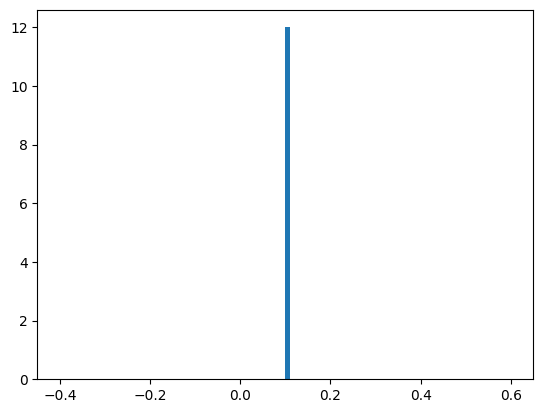

In [4]:
results['rews']
print(np.mean(results['rews'][results['rews'] > -10]))


#create a function  to print a histogram of the results['rews']
import matplotlib.pyplot as plt
plt.hist(results['rews'][results['rews'] > -10], bins=100)
plt.show()


In [5]:
from turtle import st
import torch
from tianshou.data import Batch

# load policy as in your original code
policy, optim, _ = _get_agents()
model_save_path = os.path.join("dqn_Custom", save_policy_name)        
policy_test = policy.policies['agent0']
state_saved = torch.load(model_save_path )
#print(policy_test)
policy_test.load_state_dict(state_saved)
policy_test.eval()
policy_test.set_eps(0.00)

# initialize your environment
#env = DummyVectorEnv([_get_env for _ in range(1)])
env = MultiDroneEnv(None)
env.max_time_steps = 50

# simulate the interaction with the environment manually
for i in range(10):
    for episode in range(1):  # simulate 10 episodes
        
        #env.render_speed = 1
        obs, _  = env.reset(seed=episode)         
        info         = env.get_initial_state()
        
        drones = info["drones"]
        tasks = info["tasks"]
            
        done = {0 : False}
        truncations = {0 : False}
        
        episodo_reward = 0
        #obs, reward, done, truncations, info = env.step(action)

        while not all(done.values()) and not all(truncations.values()):
            
            agent_id = "agent" + str(env.agent_selector._current_agent)
            # Create a Batch of observations
            obs_batch = Batch(obs=[obs[agent_id]], info=[{}])  # add empty info for each observation
            
            #print(obs_batch)
            # Forward the batch of observations through the policy to get the actions
            action = policy_test(obs_batch).act
            action = {agent_id : action[0]}
        
            obs, reward, done, truncations, info = env.step(action)
            
            episodo_reward += sum(reward.values())/env.n_agents

        

    print(episodo_reward)


NameError: name 'MultiDroneEnv' is not defined